# Практическое задание к уроку  
"Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях"

**взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)**

выбран: https://archive.ics.uci.edu/ml/datasets/Flags

## **Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np

from my_pipeline_selectors import FeatureSelector, OHEEncoder, NumberSelector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

**сделать обзорный анализ выбранного датасета**

In [2]:
feature_names = ["name", "landmass", "zone", "area", "population", "language", "religion", "bars", "stripes", "colours", "red", "green", "blue", "gold", "white", "black", "orange", "mainhue", "circles", "crosses", "saltires", "quarters", "sunstars", "crescent", "triangle", "icon", "animate", "text", "topleft", "botright"]

data = pd.read_csv('flag.data', names=feature_names)

In [3]:
data.head(5)

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


**сделать feature engineering**

In [4]:
data

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Western-Samoa,6,3,3,0,1,1,0,0,3,...,0,1,5,0,0,0,0,0,blue,red
190,Yugoslavia,3,1,256,22,6,6,0,3,4,...,0,0,1,0,0,0,0,0,blue,red
191,Zaire,4,2,905,28,10,5,0,0,4,...,0,0,0,0,0,1,1,0,green,green
192,Zambia,4,2,753,6,10,5,3,0,4,...,0,0,0,0,0,0,1,0,green,brown


## Будем отличать авраамические религии (христианство, ислам) от других религий

In [5]:
categorical_columns = ['topleft', 'botright', "mainhue"]
continuous_columns = ["landmass", "zone", "area", "population", "language", "bars", "stripes", "colours", "red", "green", "blue", "gold", "white", "black", "orange", "circles", "crosses", "saltires", "quarters", "sunstars", "crescent", "triangle", "icon", "animate", "text"]

final_transformers = list()

data = pd.get_dummies(data, columns=categorical_columns, prefix_sep='_')
avraamic_religion_indexes = [0, 1, 2]
data["religion"] = data["religion"].apply(lambda x: 1 if x in avraamic_religion_indexes else 0)
data.drop(columns=['name'], inplace=True)

In [6]:
data

,landmass,zone,area,population,language,religion,bars,stripes,colours,red,...,botright_red,botright_white,mainhue_black,mainhue_blue,mainhue_brown,mainhue_gold,mainhue_green,mainhue_orange,mainhue_red,mainhue_white
0,5,1,648,16,10,1,0,3,5,1,...,0,0,0,0,0,0,1,0,0,0
1,3,1,29,3,6,0,0,0,3,1,...,1,0,0,0,0,0,0,0,1,0
2,4,1,2388,20,8,1,2,0,3,1,...,0,1,0,0,0,0,1,0,0,0
3,6,3,0,0,1,1,0,0,5,1,...,1,0,0,1,0,0,0,0,0,0
4,3,1,0,0,6,1,3,0,3,1,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,6,3,3,0,1,1,0,0,3,1,...,1,0,0,0,0,0,0,0,1,0
190,3,1,256,22,6,0,0,3,4,1,...,1,0,0,0,0,0,0,0,1,0
191,4,2,905,28,10,0,0,0,4,1,...,0,0,0,0,0,0,1,0,0,0
192,4,2,753,6,10,0,3,0,4,1,...,0,0,0,0,0,0,1,0,0,0


In [7]:
from xgboost import XGBClassifier

model = XGBClassifier()

**обучить любой классификатор (какой вам нравится)**

In [8]:
import xgboost as xgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

X = data.drop(columns=['religion'])
y = data['religion']

model.fit(X, y)

xgboost_precision_scores = cross_val_score(model, X, y, cv=cv, scoring="precision_macro").mean()
xgboost_recall_scores = cross_val_score(model, X, y, cv=cv, scoring="recall_macro").mean()
xgboost_roc_auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc").mean()
xgboost_f1_score_scores = cross_val_score(model, X, y, cv=cv, scoring="f1_macro").mean()

C:\Python39\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[12:48:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly

In [9]:
data = {
    'xgboost': [
        np.mean(xgboost_precision_scores),
        np.mean(xgboost_recall_scores),
        np.mean(xgboost_roc_auc_scores),
        np.mean(xgboost_f1_score_scores)
    ]
}
before = pd.DataFrame.from_dict(data, orient='index', columns=['precision', 'recall', 'roc_auc', 'f1_score'])
before

,precision,recall,roc_auc,f1_score
xgboost,0.744572,0.702439,0.840194,0.697311


**разобраться с SHAP и построить важности признаков для:**  

In [10]:
import shap
shap.initjs()
import xgboost as xgb

**всего тестового набора данных (summary_plot - дать интерпретацию)** 

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

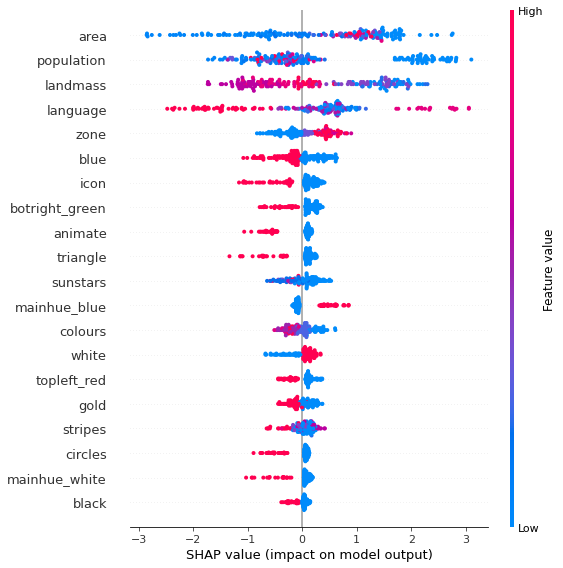

In [12]:
shap.summary_plot(shap_values, X)

**для топ 10% (сортировка по убыванию вероятности - таргета)** 

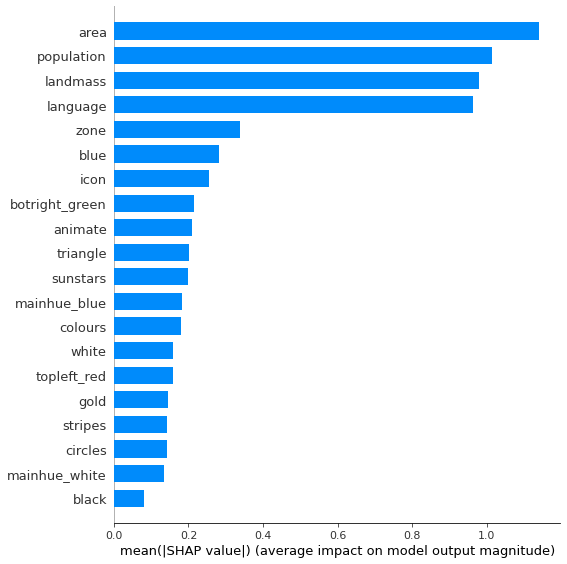

In [13]:
shap.summary_plot(shap_values, X, plot_type="bar")

## Вывод: Сразу наблюдается, что наиболее сильно на признак авраамической религии влияют не цвета флагов стран, а площадь территории, население, континенты и язык страны.

Вероятно авраамические религии хорошо приспособлены под управление большими массами людей )))

**для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат**  

In [14]:
shap.force_plot(explainer.expected_value, shap_values[0,:], pd.DataFrame(X).iloc[0,:])

Интересно, что наличие неодушевленного изображения (признак icon) является ярким признаком страны с неавраамической религией.  

(опциональное задание) для примера из вебинара (model A, model B) рассчитать shap-значения для точки {Fever=1, Cough=0}